In [1]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfn import neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

%load_ext autoreload
%autoreload 2

# Cross testing of methods

In [2]:
#X, true_y = load_wine(return_X_y=True)
X, true_y = load_breast_cancer(return_X_y=True)
mu = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - mu) / sigma

nc = 3
km = KMeans(n_clusters=nc)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: float
    instance_label: float

n = 1
cfs = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs.append(CounterfactualData([], index, float(target), label))

## Baseline

In [ ]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 73 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (769) CFs (35)
Re-training surrogate model with data size: 769
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (181) Unique overall (181)
Generated random instances: (3714)
Predicted top: 20 Counterfactuals: 15
Known alternatives: 789
Best instance score 0.7504 (X 0.97884 Y 1.0 F 0.76667), found on epoch: 0
Re-training surrogate model with data size: 789
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (181) Unique overall (360)
Generated random instances: (3698)
Predicted top: 20 Counterfactuals: 16
Found new best [-0.0929555  -0.8143917  -0.06339309 -0.20133147  0.30883801  0.44837335
  0.35862632  0.04567738 -0.54624915  0.40577359 -0.45646421 -1.0819902
 -0.45001214

## Baycon

In [4]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['classic_baycon', 'kmeans', 'model_agnostic']
run_mode = modes[2]


if run_mode == modes[0]:
    model = RandomForestClassifier()
    model.fit(X, y)
elif run_mode == modes[1]:
    model = km
elif run_mode == modes[2]:
    model = km
    # model = SpectralClustering(n_clusters=3)
else:
    raise("Invalid baycon mode")

pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(model.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="classification", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[2]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

--- Executing... Initial Instance: 73 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (769) CFs (769)
Re-training surrogate model with data size: 769
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (161) Unique overall (161)
Generated random instances: (3703)
Predicted top: 20 Counterfactuals: 20
Found new best [-0.0929555  -0.8143917  -0.06339309 -0.20133147  0.30883801  0.44837335
 -0.13696614  1.45622569  1.27037496  0.40577359 -0.45646421 -1.0819902
 -0.45001214 -0.37374478 -0.77469105 -0.26984246 -0.47426865  1.51440047
 -1.01007305 -0.25150078  0.06229254 -0.78445489  0.09051283 -0.11985999
  0.38274896  0.63572595  0.02740114  0.3607756  -0.50435235  1.05590311], with fitness score 0.4055 (X 0.95854 Y 0.47 F 0.9), oversampling
Known alternatives: 789
Best instance score 0.4055 (X 0.95854 Y 0.47 F 0.9), found on epoch: 1


## CFDE

In [5]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde_cfs

[CounterfactualData(cf=[array([-0.17232895, -0.43773394, -0.10074437, -0.22001438,  0.55539009,
         0.74610838,  0.38902807,  0.49942706, -0.54624915,  0.52772723,
        -0.08502958, -1.0819902 , -0.01783062, -0.17235697, -0.77469105,
        -0.26984246, -0.47426865, -0.42014527, -1.01007305, -0.25150078,
        -0.08822954, -0.78445489, -0.00701494, -0.15647731,  0.50757795,
         0.85364204,  0.41850744,  0.74299822, -0.50435235,  1.26592958]), array([-0.17232895, -0.4465186 , -0.10074437, -0.22001438,  0.54643811,
         0.88611115,  0.26502431,  0.49942706, -0.54624915,  0.51577775,
        -0.08502958, -1.0819902 , -0.01783062, -0.17235697, -0.77469105,
        -0.26984246, -0.47426865, -0.42014527, -1.01007305, -0.25150078,
        -0.08822954, -0.78445489, -0.00701494, -0.15647731,  0.48945053,
         0.88415607,  0.36040283,  0.74299822, -0.50435235,  1.28933999]), array([-0.17232895, -0.46389212, -0.10074437, -0.22001438,  0.50705839,
         0.8074092 ,  0.40

## CFAE

In [6]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae_cfs

[CounterfactualData(cf=[array([-0.0929555 , -0.8143917 , -0.06339309, -0.20133147,  0.30883801,
         0.44837335, -0.13696614,  0.04567738, -0.03196742,  0.61387787,
        -0.45646421, -1.0819902 , -0.45001214, -0.37374478, -0.07599954,
         1.06542249, -0.47426865, -0.42014527, -1.01007305, -0.25150078,
         0.06229254, -0.78445489,  0.09051283, -0.11985999,  0.38274896,
         0.63572595,  0.74381886,  0.3607756 , -0.50435235,  1.05590311]), array([-0.0929555 , -0.8143917 , -0.06339309, -0.20133147,  0.30883801,
         0.44837335, -0.13696614,  0.04567738,  0.27570661,  0.98045609,
        -0.45646421, -1.0819902 , -0.45001214, -0.37374478, -0.77469105,
        -0.26984246,  0.89725948,  0.11780543, -1.01007305, -0.25150078,
         0.06229254, -0.78445489,  0.09051283, -0.11985999,  0.38274896,
         0.63572595,  0.02740114,  0.3607756 , -0.50435235,  1.05590311]), array([-0.0929555 , -0.8143917 , -0.06339309, -0.20133147,  0.30883801,
         0.44837335, -0.13

## NeighborSearch

In [7]:
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, kmeans=km, instance_index=cf.instance, n=15)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

ns_cfs

[CounterfactualData(cf=array([[-4.19571826e-01, -2.60549723e-01, -3.82205243e-01,
         -4.81475582e-01,  7.99879556e-01,  5.50711340e-01,
         -1.08340811e-01,  4.69670793e-02, -6.22918958e-01,
          8.14043559e-01, -6.23570637e-01, -1.05894803e+00,
         -5.79215134e-01, -4.82653244e-01, -4.45677706e-01,
         -2.56051688e-02, -1.83481560e-01, -2.39443703e-01,
         -3.57459917e-01, -8.77179487e-02, -3.91218205e-01,
         -5.74386399e-01, -3.56572606e-01, -4.33998989e-01,
          9.17546838e-01,  8.26567861e-01,  4.12642275e-01,
          3.97319434e-01,  5.32645026e-01,  1.07252786e+00],
        [-4.18329451e-02, -8.14391699e-01, -3.49718554e-02,
         -1.57532295e-01,  6.86014849e-01,  1.69786604e-01,
          2.98816902e-01,  4.05245494e-01, -5.20692543e-01,
          3.74586301e-01, -6.65437473e-01, -4.78176552e-01,
         -6.25748011e-01, -4.72752475e-01, -5.75682977e-01,
         -4.22979794e-01, -3.33019733e-01, -3.61587581e-01,
         -1.00644

## Testing

In [8]:
baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}
cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}
cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}
nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}

methods = [baseLine, Baycon, cfde, cfae, nfs]
results, names = run(methods, centers, X, y)

print("Diversity metric - ")
print("Baseline: " + str(results["Baseline"][0][4]))
print("Baycon: " + str(results["Baycon"][0][4]))
print("CF-DE: " + str(results["CF-DE"][0][4]))
print("CF-AE: " + str(results["CF-AE"][0][4]))
print("NeighborSearch: " + str(results["NeighborSearch"][0][4]))

Diversity metric - 
Baseline: 4.908717675473859e-215
Baycon: 0.0
CF-DE: 5.843772594464768e-10
CF-AE: 0.02188209258833744
NeighborSearch: 0.1986009942879337


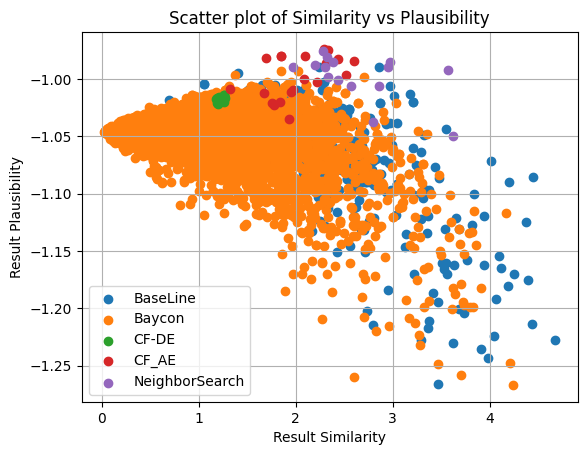

In [9]:
def plot(f1, f2, results_list, names):
    method_names = ["BaseLine", "Baycon", "CF-DE", "CF_AE", "NeighborSearch"]
    for idx, results in enumerate(results_list):
        result_x = [row[f1] for row in results]
        result_y = [row[f2] for row in results]

        plt.scatter(result_x, result_y, label=f"{method_names[idx]}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

plot(0,2, [results["Baseline"], results["Baycon"], results["CF-DE"], results["CF-AE"], results["NeighborSearch"]], names)

<Axes: >

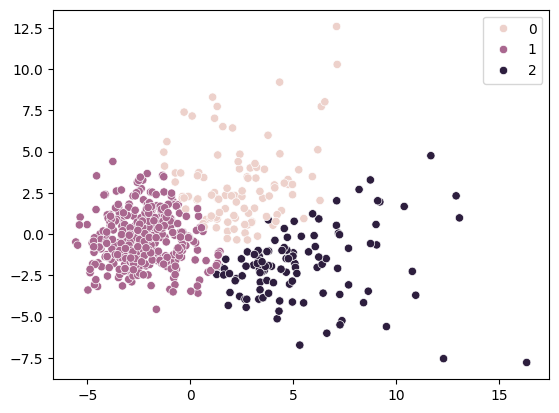

In [10]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

<Axes: title={'center': 'Instance from cluster 1 into 0'}>

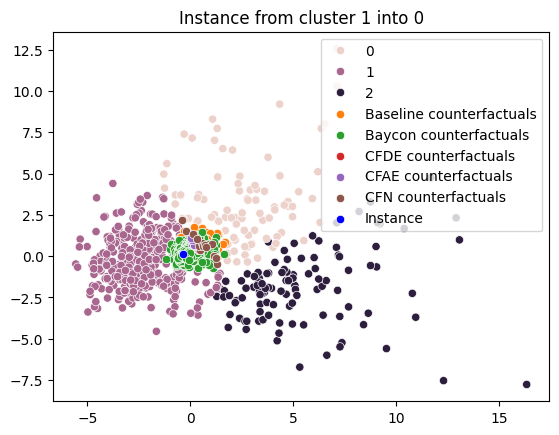

In [11]:
cf_n = 0
baseline_embed = [pca.transform(v.cf) for v in baseline_cfs][cf_n]
baycon_embed = [pca.transform(v.cf) for v in baycon_cfs][cf_n]
cfde_embed = [pca.transform(v.cf) for v in cfde_cfs][cf_n]
cfae_embed = [pca.transform(v.cf) for v in cfae_cfs][cf_n]
cfn_embed = [pca.transform(v.cf) for v in ns_cfs][cf_n]
instance_embedded = pca.transform(X[[baseline_cfs[cf_n].instance]])

ins_c = baseline_cfs[cf_n].instance_label
target_c = baseline_cfs[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {int(target_c)}")
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
sns.scatterplot(x=baseline_embed[:,0], y=baseline_embed[:,1], label="Baseline counterfactuals")
sns.scatterplot(x=baycon_embed[:,0], y=baycon_embed[:,1], label="Baycon counterfactuals")
sns.scatterplot(x=cfde_embed[:,0], y=cfde_embed[:,1], label="CFDE counterfactuals")
sns.scatterplot(x=cfae_embed[:,0], y=cfae_embed[:,1], label="CFAE counterfactuals")
sns.scatterplot(x=cfn_embed[:,0], y=cfn_embed[:,1], label="CFN counterfactuals")
sns.scatterplot(x=instance_embedded[:,0], y=instance_embedded[:,1], label="Instance", color="blue")


## Running time

In [12]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0
ns_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

    timestamp = time.time()
    i_t, new_cfs_t = neighborSearch(X=X, y=y, target=target, kmeans=km, instance_index=index, n=10)
    ns_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt
ns_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")
print(f"CFN:     {ns_rt}")


Done training classifier. Score: 1.0
--- Executing... Initial Instance: 358 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (771) CFs (0)
Re-training surrogate model with data size: 771
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (6) Unique overall (6)
Generated random instances: (3717)
Predicted top: 20 Counterfactuals: 3
Found new best [ 1.78834537 -0.68718758  0.27923496 -0.94107488 -0.9557719   0.79615165
 -0.83679475 -0.64766486  0.43220368  0.48374181  0.63476043 -0.81899883
  1.4917688  -0.2234731   1.29639292  0.1962763   0.00816603  0.52943011
  0.94776635  1.16892374 -0.2502551   1.44551548 -1.25074348  0.44260902
 -1.35315233  0.78392133  0.19113909  0.32376923 -0.75510834  1.38890215], with fitness score 0.3590 (X 0.82856 Y 1.0 F 0.43333), oversampling
Known alternatives: 791
Best instance score 0.3590 (X 0.8285

## RD-CFAE vs CFAE
*rd is random-direction

In [13]:
n = 1
cfs_div = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs_div.append(CounterfactualData([], index, float(target), label))

amount = 70

cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf2)
    cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

rd_cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    rd_cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

<Axes: title={'center': 'Instance from cluster 1 into 0'}>

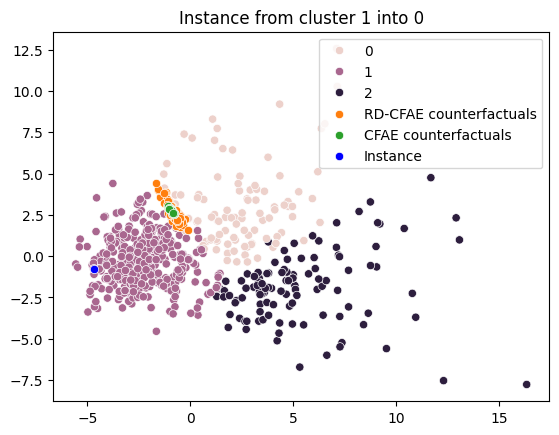

In [14]:
cf_n = 0
cfae_embed = [pca.transform(v.cf) for v in cfae_cfs_div][cf_n]
rd_cfae_embed = [pca.transform(v.cf) for v in rd_cfae_cfs_div][cf_n]
instance_embedded = pca.transform(X[[cfae_cfs_div[cf_n].instance]])

ins_c = cfae_cfs_div[cf_n].instance_label
target_c = cfae_cfs_div[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {int(target_c)}")
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
sns.scatterplot(x=rd_cfae_embed[:,0], y=rd_cfae_embed[:,1], label="RD-CFAE counterfactuals")
sns.scatterplot(x=cfae_embed[:,0], y=cfae_embed[:,1], label="CFAE counterfactuals")
sns.scatterplot(x=instance_embedded[:,0], y=instance_embedded[:,1], label="Instance", color="blue")